In [1]:
!pip install pycocotools

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.6/106.6 kB 2.4 MB/s eta 0:00:00
  Installing build dependencies ... - \ | / - \ | / done
  Getting requirements to build wheel ... - done
  Preparing metadata (pyproject.toml) ... - \ done
  Created wheel for pycocotools: filename=pycocotools-2.0.4-cp37-cp37m-linux_x86_64.whl size=370058 sha256=d178c13189a97d1dc9a5bf64701c91339028bcbc42df1312b4d3ae45bbd6f15b
  Stored in directory: /root/.cache/pip/wheels/a3/5f/fa/f011e578cc76e1fc5be8dce30b3eb9fd00f337e744b3bba59b
Successfully built pycocotools


In [2]:
# -*- coding: utf-8 -*-
import numpy as np
import pandas as pd

from pycocotools.coco import COCO  # API for interact with dataset

from PIL import Image  # to load image

# to show image
import matplotlib.pyplot as plt
import skimage.io as io
# neural networks
import torch
from torch.utils.data import IterableDataset, DataLoader
import torchvision
import torchvision.transforms.functional as F
from torchmetrics import JaccardIndex

In [3]:
def get_person_annotations(coco):
    person_id = coco.getCatIds(catNms=["person"])[0]
    ids_images_with_persons = coco.getImgIds(catIds=[person_id])
    f"{len(ids_images_with_persons)} images with person on it"

    annotations_ids = []
    for id_img in ids_images_with_persons:
        anns = coco.getAnnIds(imgIds=[id_img])
        annotations_ids.append(anns)
    f"{len(annotations_ids)} images with person on it"
    return annotations_ids, person_id

In [4]:
def get_filtered_data(coco):
    annotations_ids, person_id = get_person_annotations(coco)
    filtered_ann = []
    for num_iter, ann_id in enumerate(annotations_ids):
        skip_image = False
        count_of_persons_on_image = 0
        annotations_of_img = coco.loadAnns(ann_id)
        if len(annotations_of_img) > 15:
            # too many objects
            continue
        img = coco.loadImgs(annotations_of_img[0]["image_id"])[0]
        img_area = int(img["height"]) * int(img["width"])
        area_of_person = -1
        max_area = -1
        index_person_in_ann = 0
        for i, ann in enumerate(annotations_of_img):
            if ann["category_id"] == person_id:
                count_of_persons_on_image += 1
                area_of_person = ann["area"]
                index_person_in_ann = i
            if max_area < ann["area"]:
                max_area = ann["area"]
            if count_of_persons_on_image > 1:
                skip_image = True
                break

        if skip_image:
            continue
        if area_of_person < img_area * 0.10:
            continue
        if area_of_person != max_area:
            continue
        filtered_ann.append(annotations_of_img[index_person_in_ann])
    #     I = io.imread(img['coco_url'])
    #     plt.imshow(I)
    #     coco.showAnns(annotations_of_img)
    #     plt.show()
    f"{len(filtered_ann)} filtered images with person on it"
    return filtered_ann

In [5]:
def show_filtered_images(coco, filtered_ann):
    row_n = 4
    col_n = 7
    fig = plt.figure(figsize=(30, 8))
    for index in range(1, row_n * col_n + 1):
        annotation_of_img = filtered_ann[np.random.randint(0, len(filtered_ann))]
        img = coco.loadImgs(annotation_of_img["image_id"])[0]
        I = io.imread(img['coco_url'])
        plt.subplot(row_n, col_n, index)
        plt.imshow(I)
        plt.axis("off")
        img_area = int(img["height"]) * int(img["width"])
        person_area = annotation_of_img["area"]
        plt.title(f"persent of person {round(person_area / img_area, 3)}")
    plt.show()

In [6]:
def EDA_of_images_sizes(coco, filtered_ann):
    heights, widths = [], []
    for ann in filtered_ann:
        img = coco.loadImgs(ann["image_id"])[0]
        h, w = int(img["height"]), int(img["width"])
        heights.append(h)
        widths.append(w)

    unique_h, counts_h = np.unique(heights, return_counts=True)
    unique_w, counts_w = np.unique(widths, return_counts=True)

    fig = plt.figure(figsize=(10, 10))

    plt.subplot(2, 2, 1)
    plt.scatter(heights, widths)
    plt.xlabel("height")
    plt.ylabel("widths")

    plt.subplot(2, 2, 2)
    plt.plot(unique_h, counts_h)
    plt.xlabel("height")
    plt.ylabel("count")

    plt.subplot(2, 2, 3)
    plt.plot(unique_w, counts_w)
    plt.xlabel("width")
    plt.ylabel("count")

    plt.show()

In [7]:
def check_of_loader_work(coco, path_to_images, resize_shape, device, num_of_pictures):
    filtered_ann = get_filtered_data(coco)
    dataset = IterableDatasetCOCO(coco, path_to_images,
                                  filtered_ann, resize_shape, device, need_normalize=False)
    dataloader = DataLoader(dataset, batch_size=1)
    plt.figure(figsize=(10, 10))
    n_rows = np.int(np.sqrt(num_of_pictures * 2))
    n_cols = n_rows
    if n_cols % 2 != 0:
        n_cols += 1
    if n_rows * n_cols < num_of_pictures * 2:
        n_rows += 1
    for i, (x, y) in enumerate(dataloader):
        if i == num_of_pictures:
            break
        plt.subplot(n_rows, n_cols, i * 2 + 1)
        plt.axis("off")
        plt.imshow(x[0][0])
        plt.imshow(x[0].to(dtype=torch.int32).permute([1, 2, 0]))
        plt.subplot(n_rows, n_cols, i * 2 + 2)
        plt.axis("off")
        plt.imshow(y[0][0])
    plt.show()
    print()


def check_of_model_work(coco, path_to_images, resize_shape, model, device, num_of_pictures):
    filtered_ann = get_filtered_data(coco)
    dataset = IterableDatasetCOCO(coco, path_to_images,
                                  filtered_ann, resize_shape, device, need_normalize=True)
    dataloader = DataLoader(dataset, batch_size=1)
    to_pil = torchvision.transforms.ToPILImage()
    plt.figure(figsize=(10, 10))
    n_rows = np.int(np.sqrt(num_of_pictures * 2))
    n_cols = n_rows
    if n_cols % 2 != 0:
        n_cols += 1
    if n_rows * n_cols < num_of_pictures * 2:
        n_rows += 1
    for i, (x, y) in enumerate(dataloader):
        if i == num_of_pictures:
            break
        predict = model(x)[0]

        plt.subplot(n_rows, n_cols, i * 2 + 1)
        plt.axis("off")
        plt.imshow(to_pil(torch.argmax(y[0], dim=0).to(dtype=torch.float32)))
        plt.subplot(n_rows, n_cols, i * 2 + 2)
        plt.axis("off")
        plt.imshow(to_pil(torch.argmax(predict, dim=0).to(dtype=torch.float32)))

    plt.show()
    print()


In [8]:
def get_dataloader(coco, path_to_images, images_shape,
                   batch_size, device, limiter=0,
                   need_transformations=True, need_normalize=True):
    filtered_annotation = get_filtered_data(coco)
    if limiter > 0:
        filtered_annotation = filtered_annotation[:limiter]
    length_train_data = int(len(filtered_annotation) * 0.8)
    length_test_data = len(filtered_annotation) - length_train_data
    dataset_train = IterableDatasetCOCO(coco_module, path_to_images,
                                        filtered_annotation[:length_train_data],
                                        images_shape, device,
                                        need_transformations=need_transformations,
                                        need_normalize=need_normalize)
    dataset_test = IterableDatasetCOCO(coco_module, path_to_images,
                                       filtered_annotation[length_train_data:],
                                       images_shape, device)
    train_dataloader = DataLoader(dataset_train, batch_size=batch_size, num_workers=0)
    test_dataloader = DataLoader(dataset_test, batch_size=1, num_workers=0)
    return train_dataloader, test_dataloader, length_train_data, length_test_data


In [9]:
class IterableDatasetCOCO(IterableDataset):
    def __init__(self, coco, path_to_images, annotations, resize_shape, device,
                 need_normalize=True, need_transformations=True):
        super().__init__()
        self.coco = coco
        self.path_to_images = path_to_images
        self.annotation_of_images = annotations
        self.resize_shape = resize_shape
        self.device = device
        self.need_normalize = need_normalize
        self.need_transformations = need_transformations

        self.names_of_images = []
        self.__index = 0

        # calculated empirical by training dataset
        # mean = torch.mean(tensor_image, dim=[1, 2])
        # std = torch.std(tensor_image, dim=[1, 2])
        mean = [111.8526, 103.3080, 95.0226]
        std = [75.0907, 72.1730, 73.3086]

        self.norm = torchvision.transforms.Normalize(mean, std)
        self.resize = torchvision.transforms.Resize(self.resize_shape)

        for ann in self.annotation_of_images:
            # recording names of files, which will go to the network
            img_id = ann["image_id"]
            img = coco.loadImgs([img_id])
            self.names_of_images.append(img[0]["file_name"])

    def get_next_data(self):
        worker_info = torch.utils.data.get_worker_info()
        start = 0
        end = len(self.names_of_images)
        if worker_info is not None:
            per_worker = int(np.ceil((end - start) / float(worker_info.num_workers)))
            worker_id = worker_info.id
            start = worker_id * per_worker
            end = min(start + per_worker, end)
        names = self.names_of_images[start:end]
        for i, name in enumerate(names):
            name = self.names_of_images[start + i]
            img = Image.open(f"{self.path_to_images}/{name}")
            tensor_image = torch.tensor(np.array(img), device=self.device, dtype=torch.int32)
            if len(tensor_image.shape) != 3:
                # skip black and white  image
                continue
            tensor_image = tensor_image.permute((2, 0, 1))
            tensor_image = self.resize(tensor_image)

            image_mask = self.coco.annToMask(self.annotation_of_images[start + i])
            tensor_mask_person = torch.tensor(image_mask, device=self.device, dtype=torch.float32)
            tensor_mask_person = torch.unsqueeze(tensor_mask_person, dim=0)
            tensor_mask_person = self.resize(tensor_mask_person)
            tensor_mask_background = torch.abs(tensor_mask_person - 1)
            tensor_mask = torch.concat([tensor_mask_background, tensor_mask_person], dim=0)

            if self.need_transformations:
                tensor_image, tensor_mask = self.transformation(tensor_image, tensor_mask)

            tensor_image = tensor_image.to(dtype=torch.float32)

            if self.need_normalize:
                tensor_image = self.norm(tensor_image)

            yield tensor_image, tensor_mask

    def transformation(self, tensor_image, tensor_mask):
        p = np.random.random()
        if p < 0.5:
            tensor_image = F.hflip(tensor_image)
            tensor_mask = F.hflip(tensor_mask)
        p = np.random.random()
        if p < 0.5:
            angle = np.random.randint(-40, 40)
            tensor_image = F.rotate(tensor_image, angle)
            tensor_mask = F.rotate(tensor_mask, angle)
        p = np.random.random()
        if p < 0.5:
            factor = np.random.uniform(0.5, 1.5)
            tensor_image = F.adjust_contrast(tensor_image, factor)
        p = np.random.random()
        if p < 0.5:
            factor = np.random.uniform(0.5, 1.5)
            tensor_image = F.adjust_contrast(tensor_image, factor)
        return tensor_image, tensor_mask

    def __len__(self):
        return len(self.annotation_of_images)

    def __iter__(self):
        return iter(self.get_next_data())


In [10]:
class Block(torch.nn.Module):
    def __init__(self, inp_size, out_size, device):
        super().__init__()
        # with padding=1 output shape of result
        # will be the same with input
        self.conv1 = torch.nn.Conv2d(inp_size, out_size,
                                     kernel_size=(3, 3), padding=1, device=device)
        self.conv2 = torch.nn.Conv2d(out_size, out_size,
                                     kernel_size=(3, 3), padding=1, device=device)
        self.ReLU = torch.nn.ReLU()

    def forward(self, x):
        out = self.ReLU(self.conv1(x))
        out = self.ReLU(self.conv2(out))
        return out


class Encoder(torch.nn.Module):
    def __init__(self, shapes, device):
        super(Encoder, self).__init__()
        self.max_pooling = torch.nn.MaxPool2d((2, 2))
        # self.block_sizes = [3, 64, 128]
        self.block_sizes = shapes
        self.blocks = torch.nn.ModuleList(
            [Block(self.block_sizes[i], self.block_sizes[i + 1], device)
             for i, _ in enumerate(self.block_sizes[:-1])]
        )

    def forward(self, x):
        copy_crops = []  # for operation copy and crop
        out = x
        for block in self.blocks[:-1]:
            out = block(out)
            copy_crops.append(out)
            out = self.max_pooling(out)

        out = self.blocks[-1](out)
        # print(out.shape)
        copy_crops = copy_crops[::-1]  # this will be putted in decoder in reversed order
        return out, copy_crops


class Decoder(torch.nn.Module):
    def __init__(self, shapes, device):
        super(Decoder, self).__init__()
        # self.block_sizes = [128, 64]
        self.block_sizes = shapes
        self.blocks = torch.nn.ModuleList(
            [Block(self.block_sizes[i], self.block_sizes[i + 1], device)
             for i, _ in enumerate(self.block_sizes[:-1])]
        )
        self.transpose_convs = torch.nn.ModuleList(
            [torch.nn.ConvTranspose2d
             (self.block_sizes[i], self.block_sizes[i + 1], kernel_size=(2, 2), stride=(2, 2),
              padding=(0, 0), device=device)
             for i, _ in enumerate(self.block_sizes[:-1])]
            )

    def forward(self, x, copy_crops):
        # copy_crops for skip connection
        out = x
        for block, transpose_conv, skip in zip(self.blocks, self.transpose_convs, copy_crops):
            # print("out shape", out.shape)
            out = transpose_conv(out)
            # print("out shape trans", out.shape)
            out_width, out_height = out.shape[2:]
            skip_width, skip_height = skip.shape[2:]
            croped_height = (
                (skip_height - out_height) // 2, out_height + (skip_height - out_height) // 2)
            croped_width = (
                (skip_width - out_width) // 2, out_width + (skip_width - out_width) // 2)
            skip = skip[:, :, croped_height[0]:croped_height[1], croped_width[0]:croped_width[1]]
            # print("skip croped shape", skip.shape)
            out = torch.concat((skip, out), dim=1)
            # print("out after concat", out.shape)
            out = block(out)
            
        return out


class UNet(torch.nn.Module):
    def __init__(self, shapes, device):
        """
        :param shapes: shapes of filter in each block of encoder and decoder
        :param device:
        """
        super(UNet, self).__init__()
        self.encoder = Encoder(shapes, device)
        self.decoder = Decoder(shapes[:0:-1], device)
        self.conv1 = torch.nn.Conv2d(64, 2, kernel_size=(1, 1), device=device)
        self.SoftMax = torch.nn.Softmax(dim=1)  # along chanel dimension

    def forward(self, x):
        out, copy_crops = self.encoder(x)
        out = self.decoder(out, copy_crops)
        out = self.conv1(out)
        out = self.SoftMax(out)
        return out

    def change_mode_to_train(self):
        self.train()
        self.encoder.train()
        self.decoder.train()

    def change_mode_to_eval(self):
        self.eval()
        self.encoder.eval()
        self.decoder.eval()


In [11]:
def fit(model, model_save_path, epochs, loss_func, opt,  # scheduler,
        train_dl, test_dl, metric, len_train, len_test):
    print("start training!")
    history_loss = []
    history_metric = []

    for ep in range(epochs):
        # model.change_mode_to_train()
        for x, y in train_dl:
            y_pred = model(x)
            loss = loss_func(y_pred, y)
            opt.zero_grad()
            loss.backward()
            opt.step()
        history_loss.append(loss.item())
        with torch.no_grad():
            # model.change_mode_to_eval()
            history_metric.append(0)
            for x, y in test_dl:
                y_pred = model(x)
                history_metric[-1] += metric(y_pred, y.to(dtype=torch.int32))
            history_metric[-1] = history_metric[-1].cpu() / len_test
        print(f"№{ep}, loss {history_loss[-1]}, metric {history_metric[-1]}", end="\n")
        if ep % 10 == 0:
            torch.save(model.state_dict(), f"unet_ep_{ep}.pth")
        # scheduler.step()
    return model, history_loss, history_metric


In [12]:
coco_module = COCO("../input/coco-2017-dataset/coco2017/annotations/instances_train2017.json")

loading annotations into memory...
Done (t=24.70s)
creating index...
index created!


In [13]:
def main(coco_module):
    device = torch.device("cuda")
    print(device)
    unet = UNet([3, 64, 128, 256, 512], device)
    unet.load_state_dict(torch.load(
        "../input/checkpoint-after-10ep/unet_ep_10_128BS_0.001lr_512params.pth")
    )
    model_save_path = f"unet_.pth"
    images_path = "../input/coco-2017-dataset/coco2017/train2017"
    images_shape = (128, 128)
    epochs = 70
    loss_func = torch.nn.CrossEntropyLoss()
    batch_size = 128
    
    limiter = 0
    print(f"image size {images_shape}, epochs {epochs}, batch_size {batch_size}")
    print(f"limiter={limiter}")
    train_dataloader, test_dataloader, len_train, len_test = \
        get_dataloader(coco_module, images_path, images_shape, batch_size, device,
                       limiter=limiter, need_transformations=True)

    optm = torch.optim.Adam(unet.parameters(), lr=0.001)
    # scheduler = torch.optim.lr_scheduler.MultiStepLR(optm, [100, 150], gamma=0.9)
    metric_jaccard = JaccardIndex(2, average="macro").to(device=device)

    unet, history_loss, history_jac = \
        fit(unet, model_save_path, epochs, loss_func, optm,  # scheduler,
            train_dataloader, test_dataloader,
            metric_jaccard,
            len_train, len_test)

    plt.plot(np.arange(0, len(history_loss)), history_loss)
    plt.title("train loss")
    plt.show()

    plt.plot(np.arange(0, len(history_jac)), history_jac)
    plt.title("test metric")
    plt.show()

    return unet, history_loss, history_jac


cuda
image size (128, 128), epochs 70, batch_size 128
limiter=0
start training!
№0, loss 0.48303860425949097, metric 0.6790926456451416
№1, loss 0.47531858086586, metric 0.6844269037246704
№2, loss 0.47387421131134033, metric 0.6914302110671997
№3, loss 0.4658016264438629, metric 0.6957859992980957
№4, loss 0.471974641084671, metric 0.7032099962234497
№5, loss 0.46272778511047363, metric 0.7098438143730164
№6, loss 0.45801815390586853, metric 0.713187575340271
№7, loss 0.4566969573497772, metric 0.7124659419059753
№8, loss 0.44728532433509827, metric 0.7198112607002258
№9, loss 0.43606889247894287, metric 0.7216929197311401
№10, loss 0.4397747814655304, metric 0.7265275120735168
№11, loss 0.4230180084705353, metric 0.7281933426856995
№12, loss 0.43230709433555603, metric 0.7223817706108093
№13, loss 0.42560404539108276, metric 0.7333067059516907
№14, loss 0.42501169443130493, metric 0.7300675511360168
№15, loss 0.4249506890773773, metric 0.7348454594612122
№16, loss 0.42135995626449585

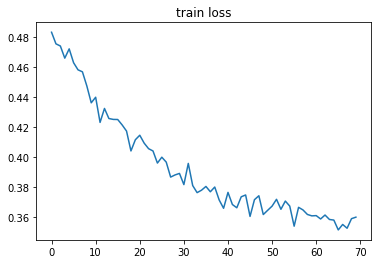

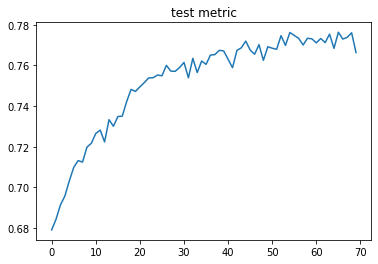

In [14]:
unet_, history_loss_, history_jac_mac_ = main(coco_module)
torch.save(unet_.state_dict(), f"unet_final_128BS_256params.pth")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


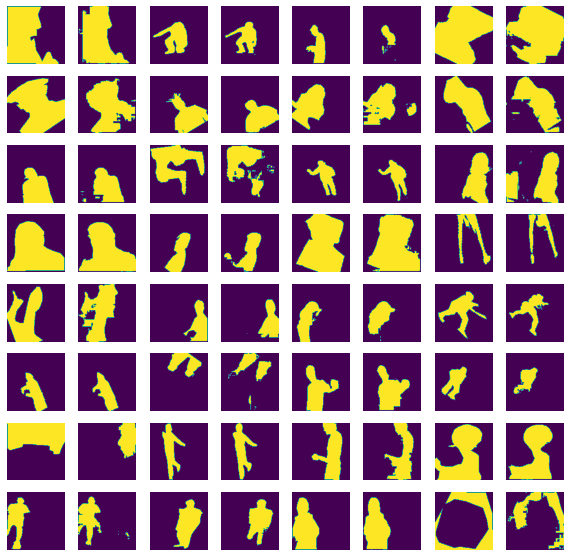

In [15]:
check_of_model_work(coco_module, "../input/coco-2017-dataset/coco2017/train2017",
                    (128, 128), unet_,
                    torch.device("cuda"), 32)

In [16]:
out = open("out_history.txt", "w")
for el in history_loss_:
    out.write(str(el))
    out.write(" ")

out.write("\n")
for el in history_jac_mac_:
    out.write(str(el))
    out.write(" ")

out.close()